# 1. Imports

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import datetime
from collections import defaultdict
import re
from scipy.stats import kruskal


from sklearn.feature_extraction.text import CountVectorizer
from pytagcloud import create_tag_image, make_tags 
from pytagcloud.colors import COLOR_SCHEMES

from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import WordPunctTokenizer
from string import punctuation
from nltk.stem import WordNetLemmatizer
import regex
import os
from pathlib import Path
colors = ['purple', 'seagreen', 'steelblue', 'c', 'm', 'y']

pygame 2.4.0 (SDL 2.26.4, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liyag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liyag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\liyag\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def import_data():
    home_dir = os.getcwd()
    tokens = pd.read_csv(Path(home_dir, "w3-latnigrin-tokens.csv"))
    headlines = pd.read_csv(Path(home_dir, "ireland-news-headlines.csv"))
    return headlines, tokens

In [3]:
headlines, tokens = import_data()

In [6]:
headlines

,publish_date,headline_category,headline_text
0,19960102,news,UUP sees possibility of voting Major out
1,19960102,news,Pubs targeted as curbs on smoking are extended
2,19960102,news,Papers reveal secret links with O'Neill cabinet
3,19960102,news,Domestic chaos as Italy takes EU presidency
4,19960102,news,Learning about the star to which we owe life
...,...,...,...
1611490,20210630,news.politics.oireachtas,Reserve members of Defence Forces to be allowe...
1611491,20210630,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...
1611492,20210630,sport.others,Andy Murray rolls back the years to own Centre...
1611493,20210630,news.health,Delta variant could do 'significant damage' in...


### ========================== Help functions ==========================

In [7]:
def plot_num_vs_year():
    unique_counts = headlines.groupby('year')['headline_text'].count()
    #create a line plot of unique text over time
    plt.figure(figsize=(8, 6))
    plt.plot(unique_counts.index, unique_counts.values )
    plt.xlabel('Date')
    plt.ylabel('Number of headlines')
    plt.title('Headlines over time')
    plt.xticks(rotation=90)
    plt.show()

In [8]:
def plot_top_10_cat_explotarion():
    fig,ax=plt.subplots(2,2,figsize=(16,16))
    Top10_category=headlines[headlines['headline_category'].isin(list(headlines.headline_category.value_counts()[:10].index[:10]))]
    sns.barplot(y=Top10_category.headline_category.value_counts().index,x=Top10_category.headline_category.value_counts(),ax=ax[0,0])
    ax[0,0].set_title("Top 10 category by counts",size=20)
    ax[0,0].set_xlabel('counts',size=18)
    ax[0,0].set_ylabel('')

    Top10_category.groupby(['year','headline_category'])['headline_category'].agg('count').unstack('headline_category').plot(ax=ax[0,1])
    ax[0,1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.10,1))
    ax[0,1].set_title("Top 10 category counts by year",size=20)
    ax[0,1].set_ylabel('counts',size=18)
    ax[0,1].set_xlabel('year',size=18)

    Top10_category.groupby(['month','headline_category'])['headline_category'].agg('count').unstack('headline_category').plot(ax=ax[1,0])
    ax[1,0].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(-0.25,1))
    ax[1,0].set_title("Top 10 category counts by month",size=20)
    ax[1,0].set_ylabel('counts',size=18)
    ax[1,0].set_xlabel('month',size=18)

    Top10_category.groupby(['day','headline_category'])['headline_category'].agg('count').unstack('headline_category').plot(ax=ax[1,1])
    ax[1,1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.10,1))
    ax[1,1].set_title("Top 10 category counts by day",size=20)
    ax[1,1].set_ylabel('counts',size=18)
    ax[1,1].set_xlabel('day',size=18)

In [9]:
def create_word_clouds():
    # Creating a clean text column
    wordnet_lemmatizer = WordNetLemmatizer()
    stop = stopwords.words('english')
    for punct in punctuation:
        stop.append(punct)
        
    def filter_text(text, stop_words):
        word_tokens = WordPunctTokenizer().tokenize(text.lower())
        filtered_text = [regex.sub(u'\p{^Latin}', u'', w) for w in word_tokens if w.isalpha()]
        filtered_text = [wordnet_lemmatizer.lemmatize(w, pos="v") for w in filtered_text if not w in stop_words] 
        return " ".join(filtered_text)
    
    headlines["filtered_text"] = headlines.headline_text.apply(lambda x : filter_text(x, stop)) 

    # Group by category and concatenate all the text rows
    grouped = headlines.groupby('main_category').agg({'filtered_text': ' '.join})

    # Get unique categories
    categories = headlines['main_category'].unique()

    # Define the size of the grid
    num_rows = 3
    num_cols = 2

    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Iterate over categories and plot in subplots
    for i, category in enumerate(categories):
        category_data = headlines[headlines['main_category'] == category] # Filter data for current category
        grouped = category_data.groupby('main_category').agg({'filtered_text': ' '.join}) # Group by category and concatenate text
        vectorizer = CountVectorizer(stop_words='english') # Create a vectorizer and fit it to the text data
        token_counts = vectorizer.fit_transform(grouped['filtered_text'])
        counts = token_counts.sum(axis=0) # Sum the token counts across all the text
        # Create DataFrame with token and count columns
        token_counts_df = pd.DataFrame({
            'token': vectorizer.get_feature_names_out(),
            'count': counts.tolist()[0]
        })

        # Sort by count in descending order and select top 100
        top_tokens = token_counts_df.sort_values('count', ascending=False).head(100)
        top_tokens_list = list(zip(top_tokens['token'], top_tokens['count']))
        # Convert the list of tuples to a list of tags
        tags = make_tags(top_tokens_list, minsize=15, maxsize=60,colors=COLOR_SCHEMES['audacity'], scalef=my_scalef)
        create_tag_image(tags, f'wordcloud_{category}.png')
        # Load the image file
        img = plt.imread(f'wordcloud_{category}.png')
        # Plot in the corresponding subplot
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(category, fontsize=18)

    # Hide unused subplots, if any
    for j in range(len(categories), num_rows*num_cols):
        axes[j].axis('off')
    plt.show()

In [10]:
def main_cat_dist():
    ## here it is different from what you did 
    headlines[['temp_main_category', 'temp_sub_category']] = headlines['headline_category'].str.split('.', n=1, expand=True)
    headlines['temp_sub_category'].fillna('None', inplace=True)

    # Get unique main categories
    unique_main_categories = headlines['temp_main_category'].unique()

    fig, ax = plt.subplots(figsize=(8, 5))
    main_dict = dict(headlines['temp_main_category'].value_counts())
    ax.bar(main_dict.keys(), main_dict.values(), color=colors)
    ax.set_title('Main categories distribution', fontsize = 15)

In [36]:
def sub_cat_dist():
    unique_main_categories = headlines['temp_main_category'].unique()
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    # Loop over the main categories and create subplots for each one
    for i, main_category in enumerate(unique_main_categories):
        # Filter the data to include only the current main category

        row = i // 2
        col = i % 2
        cat_dict = dict(headlines[headlines['temp_main_category']==main_category]['temp_sub_category'].value_counts())

        axs[row, col].bar(cat_dict.keys(),cat_dict.values(), color=colors[i % len(colors)])

        # Set the title and x-axis label for the histogram
        axs[row, col].set_title(main_category, fontsize = 20)
        axs[row, col].set_xticklabels(cat_dict.keys(), rotation=90, fontsize=10)

    # Adjust the spacing between subplots
    plt.tight_layout()
    # Show the plot
    plt.show()

In [12]:
def length_dist():
    headlines['length'] = [len(x.split(' ')) for x in headlines['headline_text']]

    plt.figure(figsize=(10,5))
    plt.hist(headlines['length'], bins=40, color='crimson')

    plt.title('Headlines length distribution', fontsize =15)
    plt.axvline(x=headlines['length'].min(), color='black', linestyle='--')
    plt.axvline(x=headlines['length'].median(), color='black', linestyle='-.')
    plt.axvline(x=headlines['length'].mean(), color='black')
    plt.axvline(x=headlines['length'].max(), color='black', linestyle='--')

    plt.legend(['min','median','mean','max'], fontsize = 15)
    plt.show()
    
    my_dict = {}
    unique_main_categories = headlines['temp_main_category'].unique()

    for main_category in unique_main_categories:
        my_dict[main_category] = headlines[headlines['temp_main_category']==main_category]['length']

    fig, ax = plt.subplots(figsize = (10,5))
    # rectangular box plot
    bplot1 = ax.boxplot(my_dict.values(),
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=my_dict.keys())  # will be used to label x-ticks
    ax.set_title('Headlines length box plot')

    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

    plt.show()

In [13]:
def kruskal_test():
    my_dict = {}
    unique_main_categories = headlines['temp_main_category'].unique()

    for main_category in unique_main_categories:
        my_dict[main_category] = headlines[headlines['temp_main_category']==main_category]['length']
    
    res = []
    array = [i.tolist() for i in my_dict.values()]
    min_num = min([len(i) for i in array])
    for i in array:
        res.append(i[:min_num])

    # Perform the Kruskal-Wallis test
    h, p = kruskal(res[0],res[1],res[2],res[3],res[4],res[5])

    # Print the results
    if p < 0.05:
        print("The lists are from different distributions.")
    else:
        print("The lists are from the same distribution.")


In [14]:
def get_words_freq():
    # Extract the titles column from the DataFrame
    titles = headlines["filtered_text"] 

    # Create a word frequency dictionary to store the count of each word
    word_freq = defaultdict(int)

    # Iterate over each title and split it into individual words
    for title in titles:
        # Convert title to lowercase
        title = title.lower()
        # Split the title into words using regex pattern
        words = re.findall(r'\b\w+\b', title)
        # Update the word frequency dictionary
        for word in words:
            word_freq[word] += 1

    # Get the word counts
    word_counts = list(word_freq.values())
    return word_counts, word_freq

In [41]:
def preq_plot(word_counts):
    # Define the number of bins
    num_bins = 500

    # Create histogram bins
    hist, bin_edges = np.histogram(word_counts, bins=num_bins)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
    plt.xlabel('Number of Appearances')
    plt.ylabel('Number of Words')
    plt.title('Word Frequency Histogram')
    plt.savefig('Word Frequency Histogram.jpg', dpi = 600)
    plt.show()
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
    plt.xlabel('Number of Appearances')
    plt.ylabel('Number of Words')
    plt.title('Long Tail Word Frequency Histogram')
    plt.ylim(0,10)
    plt.savefig('Long Tail Word Frequency Histogram.jpg', dpi = 600)
    plt.show()
    
    # Define the number of bins
    num_bins =50000

    # Create histogram bins
    hist, bin_edges = np.histogram(word_counts, bins=num_bins)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
    plt.xlabel('Number of Appearances')
    plt.ylabel('Number of Words')
    plt.title('Head Word Frequency Histogram')
    plt.xlim(0,10)
    plt.savefig('Head Word Frequency Histogram.jpg', dpi = 600)
    plt.show()

In [16]:
def filter_frequent_words(word_freq, min_num=1, max_num=40000):
    irrelevant_words = []
    for word, num in word_freq.items():
        if (num<min_num) | (num>max_num):
            irrelevant_words.append(word)

    def filter_words(text):
        text = text.split(' ')
        res = ""
        for i in text:
            if i in irrelevant_words:
                pass
            else:
                res+= i+' '
        return res[:-1]

    headlines['filtered_text_2'] = [filter_words(x) for x in headlines['filtered_text']]

In [17]:
def data_exploration():
    print("======================= Data Exploration =======================\n")
    print(f"Number of rows: {headlines.shape[0]}")
    num_of_categories = headlines.groupby(['headline_category']).nunique().sort_values(by='headline_text',ascending=False).shape[0]
    print(f'Total number of categories is {num_of_categories}\n')
    print('Number of null values:')
    print(headlines.isnull().sum(axis=0),'\n')
    print('Number of duplicates:', headlines.duplicated().sum())
    print('But! Number of rows with the same header: ', headlines[['headline_text','headline_category']].duplicated().sum())
    print('In the preprocessing phase we will keep just the last version of the duplicates')

In [18]:
def my_scalef(count, mincount, maxcount, minsize, maxsize):
    return int(minsize + (maxsize - minsize) * 
               (count * 1.0 / (maxcount - mincount)) ** 0.9)

In [19]:
def preprocessing(headlines):
    print("======================= Data Basic Preprocessing =======================\n")

    print(f'Number of nulls before preprocessing: {headlines.isnull().sum().sum()}')
    print('Number of duplicates before preprocessing: '+str(headlines[['headline_text','headline_category']].duplicated().sum()))
    print(f'Number of rows before preorocessing: {headlines.shape[0]}')

    print('Processing...\n')
    headlines=headlines.dropna()
    headlines=pd.DataFrame(headlines.groupby(['headline_text','headline_category'])['publish_date'].max()).reset_index()
    print(f'Number of nulls after preprocessing: {headlines.isnull().sum().sum()}')
    print('Number of duplicates after preprocessing: '+str(headlines[['headline_text','headline_category']].duplicated().sum()))
    print(f'Number of rows after removing nulls and duplicates: {headlines.shape[0]}')
    print(' :) ')
    
    # creating proper date year month and day comlumns for the analysis over time 
    headlines['date']=headlines.publish_date.apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d').strftime('%Y-%m-%d'))
    headlines['year']=headlines.date.apply(lambda x:x.split('-')[0])
    headlines['month']=headlines.date.apply(lambda x:x.split('-')[1])
    headlines['day']=headlines.date.apply(lambda x:x.split('-')[2])
    
    # Creating a Column for each category
    headlines[['main_category', 'mid_category', 'sub_category']] = headlines['headline_category'].str.split('.', n=2, expand=True)
    
    return headlines

# 2. Data Basic Exploration

In [20]:
data_exploration()

======================= Data Exploration =======================

Number of rows: 1611495
Total number of categories is 103

Number of null values:
publish_date         0
headline_category    0
headline_text        7
dtype: int64 

Number of duplicates: 0
But! Number of rows with the same header:  86916
In the preprocessing phase we will keep just the last version of the duplicates


# 3. Data Preprocessing

In [21]:
headlines = preprocessing(headlines)

======================= Data Basic Preprocessing =======================

Number of nulls before preprocessing: 7
Number of duplicates before preprocessing: 86916
Number of rows before preorocessing: 1611495
Processing...

Number of nulls after preprocessing: 0
Number of duplicates after preprocessing: 0
Number of rows after removing nulls and duplicates: 1524575
 :) 


# 4. Data Visualization 

## 4.1 Showing number of headlines over the years

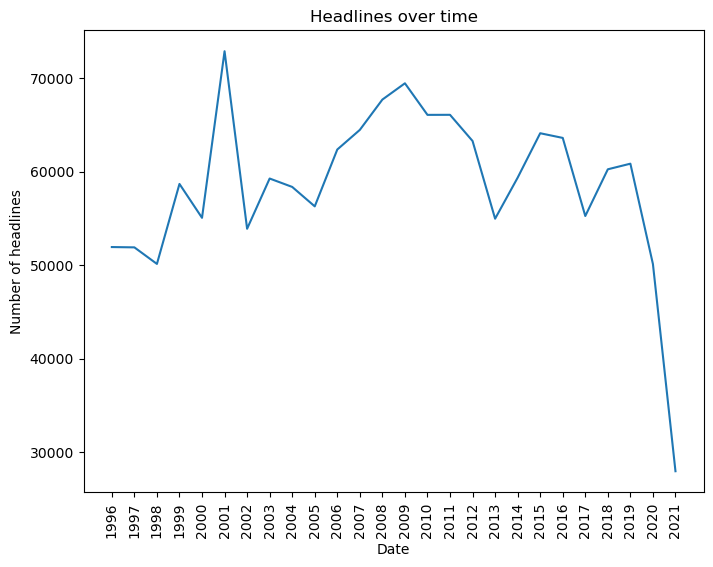

In [23]:
plot_num_vs_year()

## 4.2 Showing the amount of headlines per category over the years

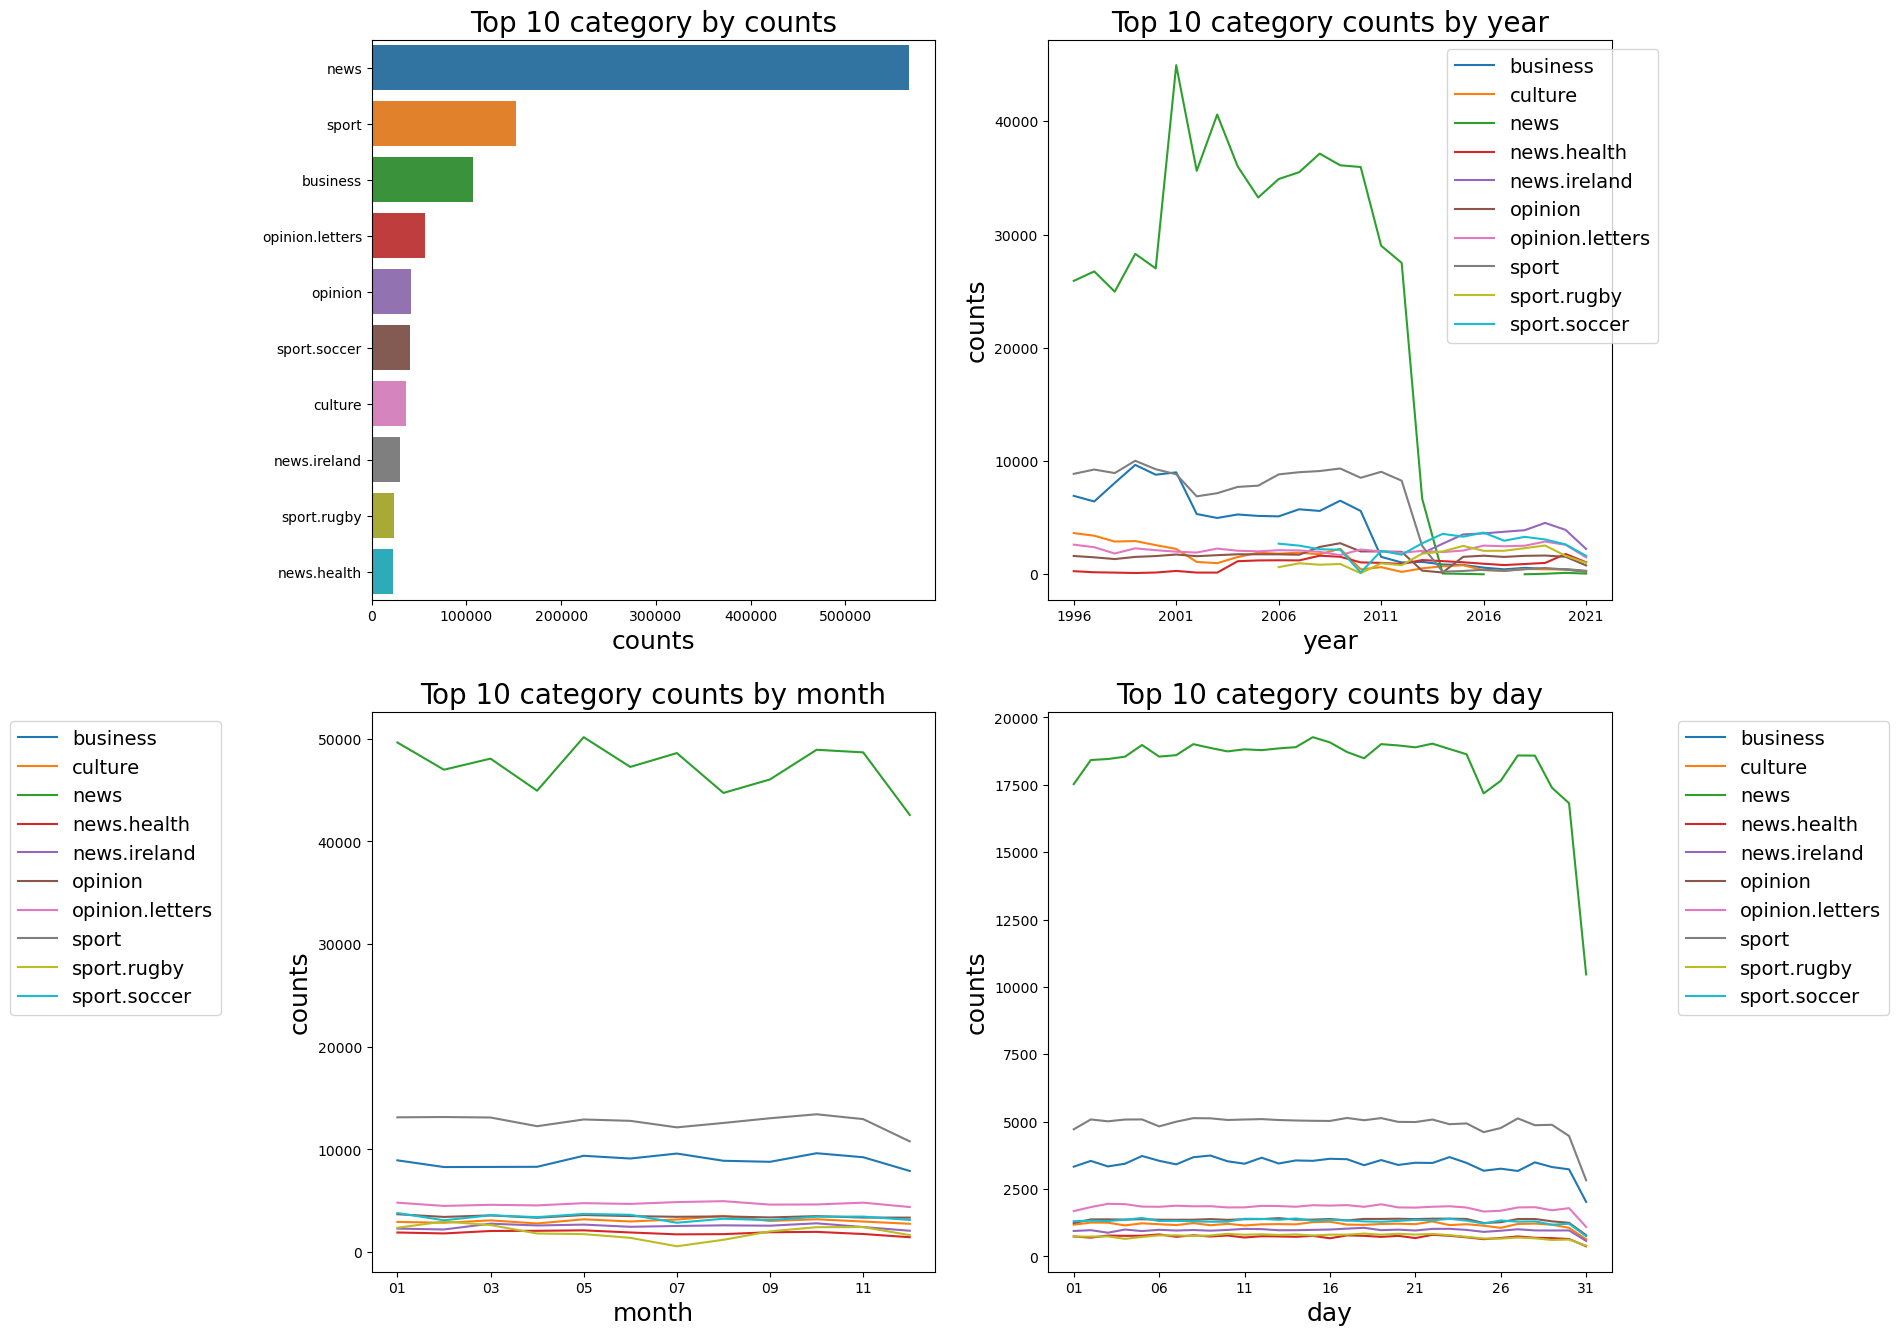

In [24]:
plot_top_10_cat_explotarion()

## 4.3 Creating word clouds for every category

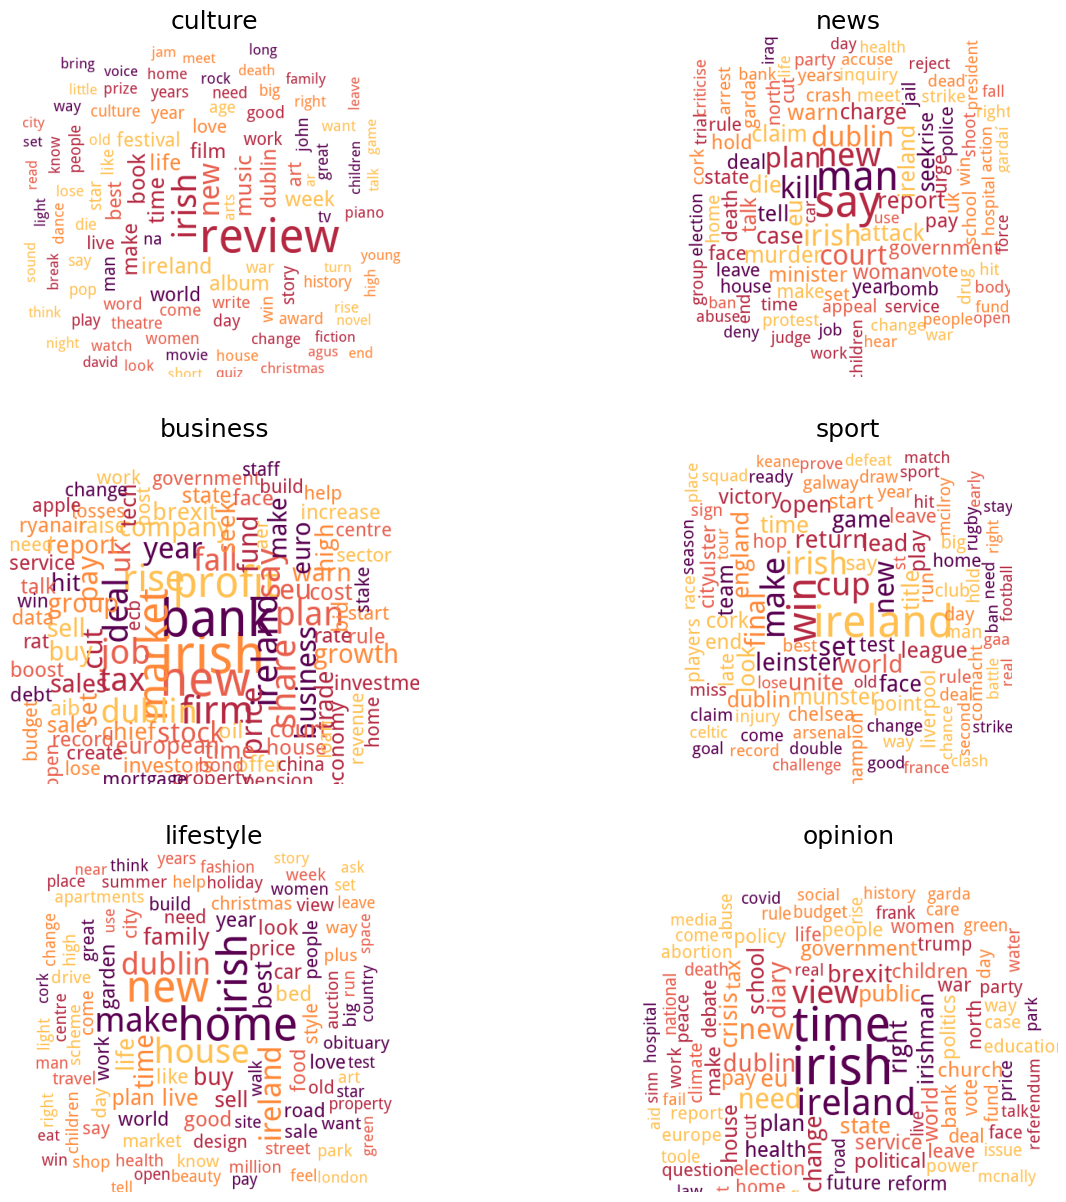

In [25]:
create_word_clouds()

## 4.4. Explore main categories distribution

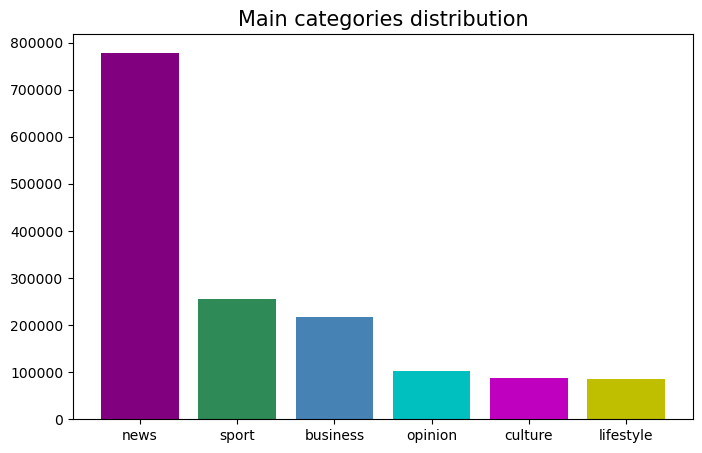

In [26]:
main_cat_dist()

C:\Users\liyag\AppData\Local\Temp\ipykernel_8952\2372876035.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(cat_dict.keys(), rotation=90, fontsize=10)
C:\Users\liyag\AppData\Local\Temp\ipykernel_8952\2372876035.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(cat_dict.keys(), rotation=90, fontsize=10)
C:\Users\liyag\AppData\Local\Temp\ipykernel_8952\2372876035.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(cat_dict.keys(), rotation=90, fontsize=10)
C:\Users\liyag\AppData\Local\Temp\ipykernel_8952\2372876035.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(cat_dict.keys(), rotation=90, fontsize=10)
C:\Users\liyag\AppData\Local\Temp\ipykernel_8952\2372876035.py:16: UserWarning: FixedFormatter should only be used together with Fix

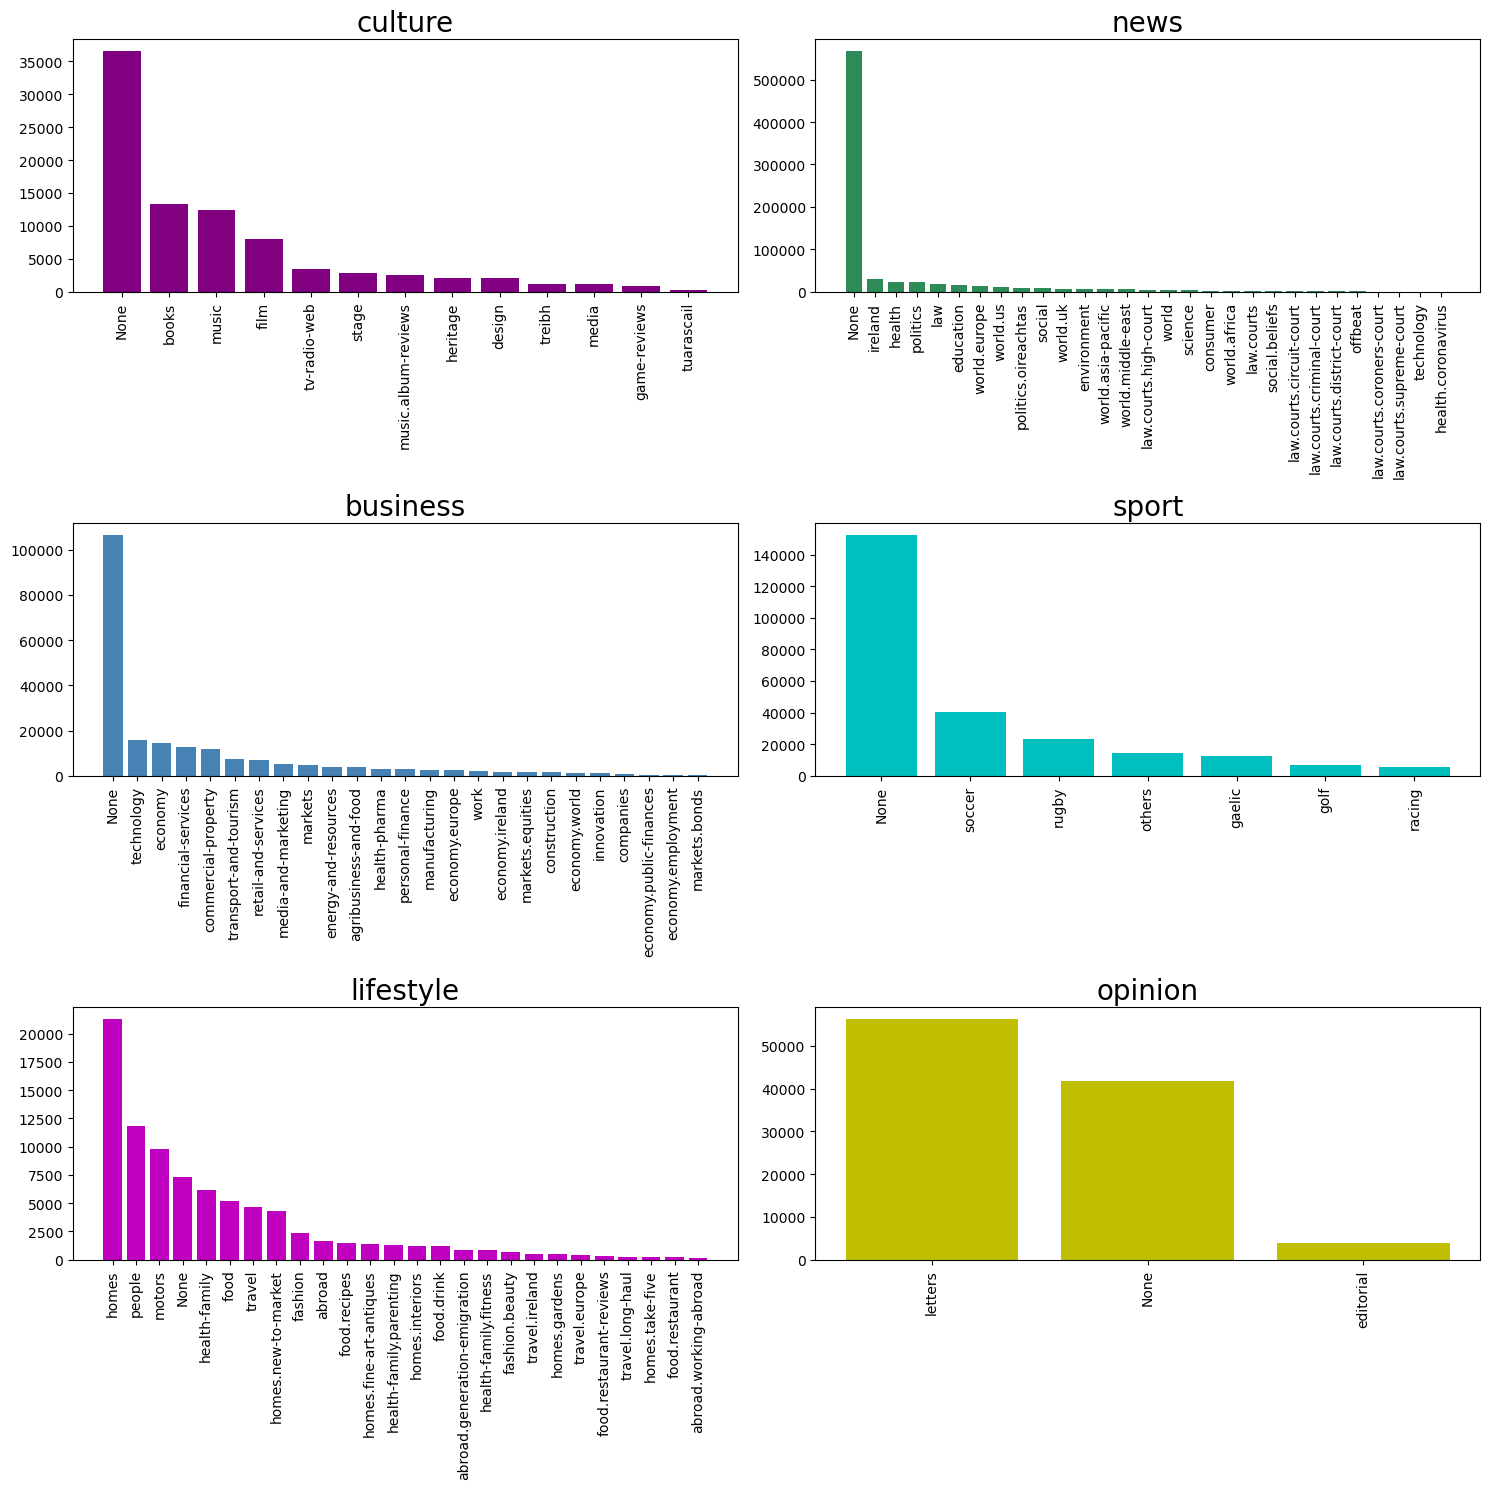

In [37]:
sub_cat_dist()

## 4.5. Explore headlines length distribution 

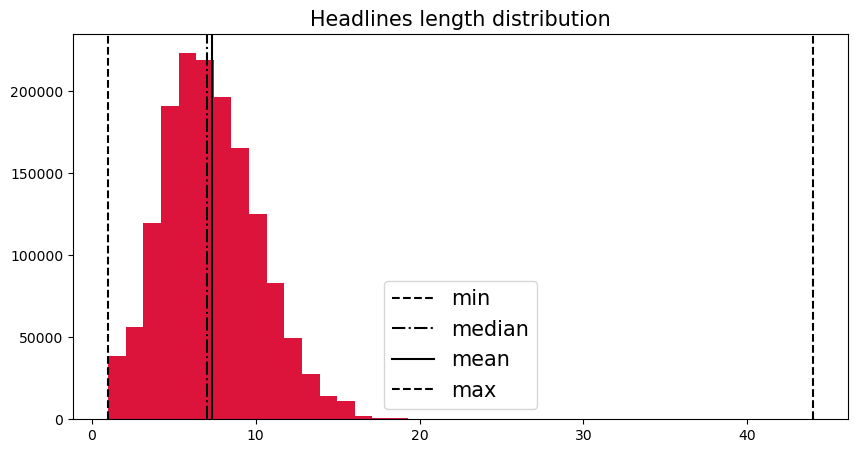

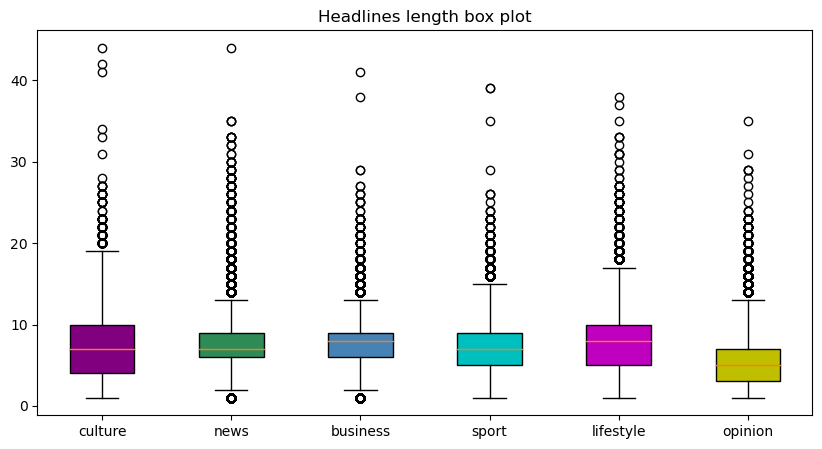

In [38]:
length_dist()

### 4.5.1. Check if the headlines length is statistically dependent on the category

In [39]:
kruskal_test()

The lists are from different distributions.


## 4.6. Explore the number of occurrences of each word

In [40]:
word_counts, word_freq = get_words_freq()

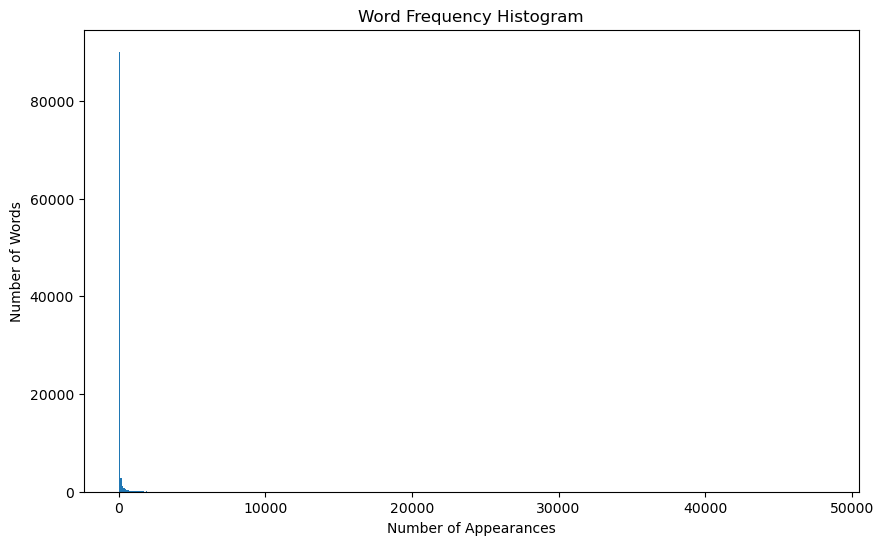

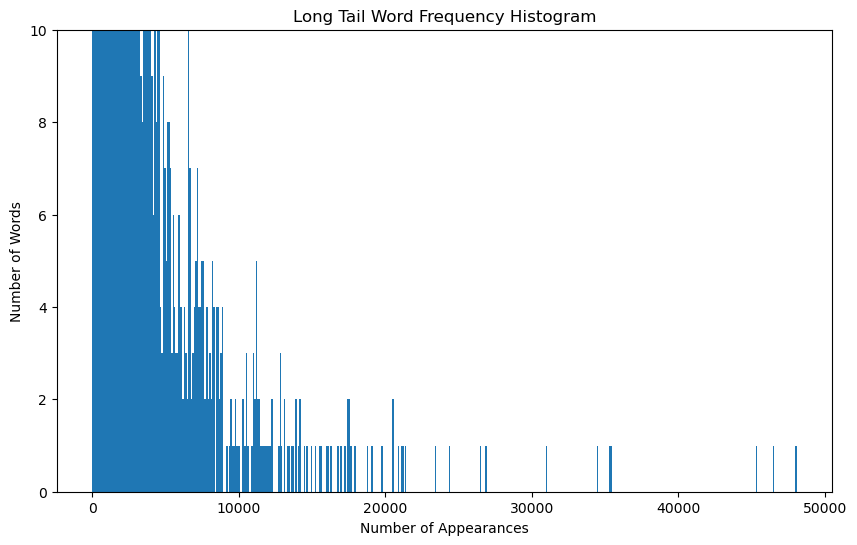

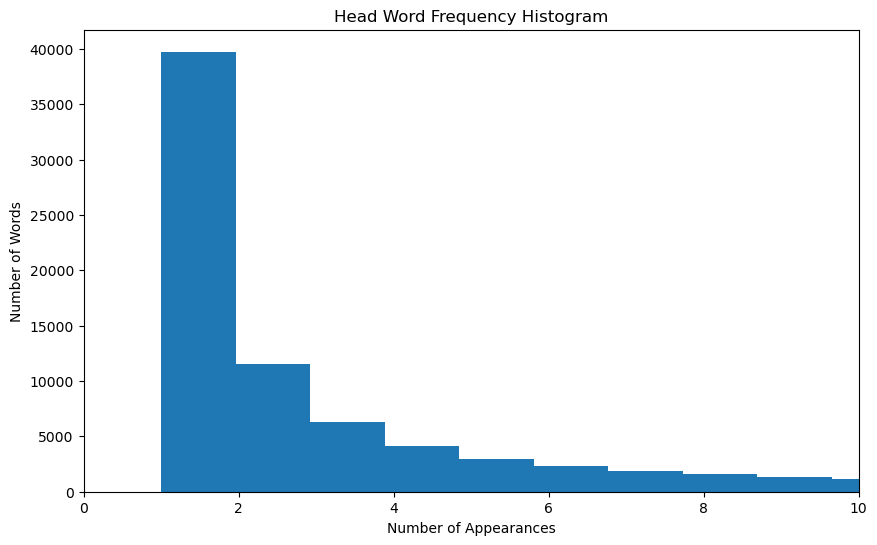

In [42]:
preq_plot(word_counts)

# 5. More preprocessing:
## Filter most and least frequent words

In [43]:
filter_frequent_words(word_freq, 1, 40000)

## Prune the data to have a balanced and smaller dataset

In [46]:
headlines

,headline_text,headline_category,publish_date,date,year,month,day,main_category,mid_category,sub_category,filtered_text,temp_main_category,temp_sub_category,length,filtered_text_2
0,!!!: Thr!!!er,culture.music,20130426,2013-04-26,2013,04,26,culture,music,None,thr er,culture,music,2,thr er
1,!Ay; Carmela!,culture,19991008,1999-10-08,1999,10,08,culture,None,None,ay carmela,culture,None,2,ay carmela
2,!Viva el documental!,news,20030222,2003-02-22,2003,02,22,news,None,None,viva el documental,news,None,3,viva el documental
3,!kaboogie,culture,20090717,2009-07-17,2009,07,17,culture,None,None,kaboogie,culture,None,1,kaboogie
4,#1 million art theft from gallery in Manchester,news,20030428,2003-04-28,2003,04,28,news,None,None,million art theft gallery manchester,news,None,8,million art theft gallery manchester
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524570,€9m priced sewer cost €83m after contract 'coc...,news,20080215,2008-02-15,2008,02,15,news,None,None,price sewer cost contract cock,news,None,8,price sewer cost contract cock
1524571,€9m to be spent on new rural transport plan,news,20070220,2007-02-20,2007,02,20,news,None,None,spend new rural transport plan,news,None,9,spend rural transport plan
1524572,€ulogy for the old currency,news,20020105,2002-01-05,2002,01,05,news,None,None,ulogy old currency,news,None,5,ulogy old currency
1524573,╙ SΘ gracious at end of testing match,sport,20010903,2001-09-03,2001,09,03,sport,None,None,gracious end test match,sport,None,8,gracious end test match


In [44]:
preprocessed_df = headlines[['main_category', 'filtered_text_2']]
preprocessed_df=pd.DataFrame(preprocessed_df.groupby(['filtered_text_2'])['main_category'].max()).reset_index()
preprocessed_df = preprocessed_df[preprocessed_df['filtered_text_2'].str.contains('[a-zA-Z]')].reset_index(drop=True)

In [45]:
num_to_truncate = min(preprocessed_df.groupby(['main_category'])['filtered_text_2'].count())
main_categories = preprocessed_df['main_category'].unique()

print(num_to_truncate)
print(main_categories)

80992
['opinion' 'news' 'business' 'culture' 'lifestyle' 'sport']


In [47]:
final_df = pd.DataFrame(columns=['main_category','filtered_text_2'])
for category in main_categories:
    df = preprocessed_df[preprocessed_df['main_category']==category].sample(num_to_truncate, replace = False)
    final_df = pd.concat([final_df,df], ignore_index=True)
    
final_df = final_df.sample(frac=1, ignore_index=True) # shuffle the data 

# 6. Save preprocessed data frame 

In [49]:
final_df

,main_category,filtered_text_2
0,news,hse warn three years ago system weaknesses
1,culture,absorb tale friendship across frontiers
2,opinion,whether desperate shrewd murdoch certainly coward
3,opinion,protect arts
4,business,permanent tsb seek tender loan book sale
...,...,...
485947,news,starr raise possibility impeach clinton lewins...
485948,culture,ticket award result favourite film
485949,opinion,time put clock back
485950,opinion,mckevitt clinton buddy kerry


In [50]:
final_df.to_csv('preprocessed_df.csv')